# Atelier 1 : Denoising parfaitement supervisé

In [1]:
# Pour commencer : aller dans éxecution/modifier le type d'exécution et vérifier
# que CPU est bien coché (on n'a pas besoin de plus pour l'instant)

# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/nanopiero/spatialisation_grele

Cloning into 'spatialisation_grele'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [4]:
! ls spatialisation_grele

apprentissage.ipynb  presentation.ipynb


## A. Découverte du problème

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Le 25/04/2024
@author: lepetit
#fonctions utiles pour l'atelier PREAC
"""

import torch
import numpy as np
from random import randint
import matplotlib.pyplot as plt

import torch
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os


In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Le 03/06/2024
@author: lepetit
# fonctions utiles pour la génération
# de données à fusionner
"""
from random import randint
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy

##############################
########## with JIT ##########
##############################
from numba import jit
from numpy.random import randint




@jit(nopython=True)
def pseudo_meshgrid(size):
  b = np.arange(0, size).repeat(size).reshape(1,size,size)
  a = np.transpose(b, (0,2,1))
  return  a, b


@jit(nopython=True)
def simu_moving_disc(image, a, b):
  nsteps, size, _ = image.shape

  # Initialize centers and radii arrays
  centers = np.zeros((nsteps, 2))
  radii = np.zeros(nsteps)

  # Choose k
  k = np.random.randint(0,size)

  # Generate the kth center and radius
  radius_k = np.abs(np.random.normal(10, 8))
  center_k = radius_k + (size - radius_k) * np.random.random(2)

  # Generate advection speed and radius increment
  advection_speed = np.random.normal(0, 3, 2)
  radius_increment = np.random.normal(0, 8/nsteps)

  # Fill centers and radii arrays
  abs_centers = center_k[0] + (np.arange(nsteps) - k) * advection_speed[0]
  ord_centers = center_k[1] + (np.arange(nsteps) - k) * advection_speed[1]
  radii = radius_k  +  (np.arange(nsteps) - k) * radius_increment
  radii[radii <= 0] = 0

  distances_to_centers = (a - abs_centers.reshape((nsteps, 1, 1)))**2 + \
                         (b - ord_centers.reshape((nsteps, 1, 1)))**2

  discs =  1. * (distances_to_centers < radii.reshape(nsteps, 1, 1)**2)
  # discs =  (0.39 - 0.36*distance_to_centers/radii**2)*(distances_to_centers < radii**2)

  # apply a random intensity
  discs *= np.random.uniform(0.1,1.)
  image = image + discs
  return image

# @jit(nopython=True)
def generate_cell_and_hail_characteristics(nsteps, size, centered,
                                           relative_advection_speed,
                                           smajor_axis_k=None,
                                           eccentricity_k=None,
                                           theta_increment=None,
                                           intensity=None):
    # Choose k
    k = np.random.randint(2, nsteps-2)

    # Generate the kth major_axis, minor_axis,  center, rotation, focus, and radius
    if smajor_axis_k is None:
      smajor_axis_k = 5 + np.abs(np.random.normal(10, 15))

    if centered:
      center_k = np.array([size // 2, size //2 ])
    else:
      center_k = smajor_axis_k + (size - smajor_axis_k) * np.random.random(2)

    if eccentricity_k is None:
      eccentricity_k = 0.2 + 0.8 * np.random.rand()

    theta_k = np.pi * np.random.rand()

    # Generate advection speed and radius increment
    if centered:
      relative_advection_speed = 2*np.random.normal(0, 3, 2)
      advection_speed = np.zeros(2)
    else:
      advection_speed = 2*np.random.normal(0, 3, 2) - relative_advection_speed

    smajor_axis_increment = np.random.normal(0, 1/nsteps)
    eccentricity_increment = 2/nsteps * np.random.rand()

    if theta_increment is None:
      theta_increment = np.random.normal(0, np.pi/nsteps)

    # Fill centers and radii arrays
    abs_centers = center_k[0] + (np.arange(nsteps) - k) * advection_speed[0]
    ord_centers = center_k[1] + (np.arange(nsteps) - k) * advection_speed[1]

    smajor_axis = smajor_axis_k + (np.arange(nsteps) - k) * smajor_axis_increment
    smajor_axis[smajor_axis <= 0] = 0
    eccentricity = eccentricity_k  +  (np.arange(nsteps) - k) * eccentricity_increment
    eccentricity[eccentricity <= 0] = -1*eccentricity[eccentricity <= 0]
    eccentricity[eccentricity >= 0.9] = 0.9
    theta = theta_k  +  (np.arange(nsteps) - k) * theta_increment

    # Get intensity of the cell and hail characteristics:
    ratio_hail = 0.3
    if intensity is None:
      intensity = np.random.uniform(0.3,0.8)

    radius = ratio_hail * eccentricity * smajor_axis
    radius = radius.reshape((nsteps, 1, 1))
    hail_steps = (intensity > 0.5) * (theta_increment <= 0) * (radius > 3)
    hail_size = 10/(size**2) * np.pi * smajor_axis**2 * np.sqrt(1 - eccentricity**2) # hail size prop to the area

    return abs_centers, ord_centers, smajor_axis, eccentricity, \
           theta, theta_increment, intensity, hail_steps, hail_size, radius

# @jit(nopython=True)
def simu_moving_ellipse(image, a, b, stratification=None,
                        centered=False, relative_advection_speed=np.zeros(2), add_target=True):
  nsteps, nchannels, size, _ = image.shape

  if stratification is None:
    abs_centers, ord_centers, smajor_axis, eccentricity, \
      theta, theta_increment, intensity, hail_steps, hail_size, radius = \
      generate_cell_and_hail_characteristics(nsteps,  size, centered, relative_advection_speed)
  elif stratification == 'occurrence':
    toss = (torch.rand(1,) > 0.7).item()
    if toss :
      theta_increment = - np.abs(np.random.normal(0, np.pi/nsteps))
      intensity = np.random.uniform(0.5, 0.8)
      abs_centers, ord_centers, smajor_axis, eccentricity, \
        theta, theta_increment, intensity, hail_steps, hail_size, radius = \
        generate_cell_and_hail_characteristics(nsteps,  size, centered,
                                               relative_advection_speed,
                                               theta_increment=theta_increment,
                                               intensity=intensity
                                               )


  elif stratification == 'size':

  nb_hail_steps = hail_steps.sum()
  max_hail_size = hail_steps.max()


  # Make the cells:
  delta_abs_interfocus = eccentricity * smajor_axis * np.cos(theta)
  delta_ord_interfocus = eccentricity * smajor_axis * np.sin(theta)

  abs_focus1 = abs_centers + delta_abs_interfocus
  ord_focus1 = ord_centers + delta_ord_interfocus
  abs_focus2 = abs_centers - delta_abs_interfocus
  ord_focus2 = ord_centers - delta_ord_interfocus

  distances_to_focus1 = (a - abs_focus1.reshape((nsteps, 1, 1)))**2 + \
                         (b - ord_focus1.reshape((nsteps, 1, 1)))**2
  distances_to_focus2 = (a - abs_focus2.reshape((nsteps, 1, 1)))**2 + \
                         (b - ord_focus2.reshape((nsteps, 1, 1)))**2

  sum_distances = np.sqrt(distances_to_focus1) + np.sqrt(distances_to_focus2)
  ellipses =  1. * (sum_distances < 1.25 * 2*smajor_axis.reshape(nsteps, 1, 1))

  # apply a random intensity
  intensity = np.random.uniform(0.3,0.8)
  ellipses *= intensity
  image[:,0] = image[:,0] + ellipses

  # Make ground truth
  if (intensity > 0.5) and (theta_increment <= 0) and add_target:
    twocircles = (radius**2 - distances_to_focus1) * (distances_to_focus1 < radius**2) \
                + (radius**2 - distances_to_focus2) * (distances_to_focus2 < radius**2)
    twocircles *= hail_steps
    # Normalisation:
    eps = 0.0001
    twocircles /= np.max(twocircles, axis=(1,2)).reshape((nsteps, 1, 1)) + eps
    # hail size prop to the area :
    twocircles *= hail_size.reshape((nsteps, 1, 1))
    image[:,1] += twocircles
  else:
    pass
  return image, relative_advection_speed



@jit(nopython=True)
def resize_channel(channel, new_size):
    x = np.linspace(0, 1, channel.shape[0])
    y = np.linspace(0, 1, channel.shape[1])
    x_new = np.linspace(0, 1, new_size)
    y_new = np.linspace(0, 1, new_size)
    return np.interp(x_new[:, None] + y_new[None, :], x, np.interp(y_new, y, channel))

# @jit(nopython=True)
def spatialized_gt(ndiscs=5, size=64, nsteps=60, stratification=None, centered=False):
  image=np.zeros((nsteps, 2, size, size))
  a, b = pseudo_meshgrid(size)

  if centered:
    image, relative_advection_speed0 = simu_moving_ellipse(image, a, b,
                                                           stratification,
                                                           centered=True)
    for i in range(ndiscs - 1):
      image, _ = simu_moving_ellipse(image, a, b, centered=False,
                                     relative_advection_speed=relative_advection_speed0,
                                     add_target=False)
  else:
    for i in range(ndiscs):
      image, _ = simu_moving_ellipse(image, a, b, stratification)
  return image





##############################
########## Datasets ##########
##############################

from torch.utils.data import Dataset

class FusionDataset(Dataset):
    def __init__(self, length_dataset=6400, npairs=10, nsteps=60, ndiscs=5, size_image=64):
        """
        Args:
              I need a pytorch dataset that will simply embed two numpy function that generates random tensors.
              These functions, called spatialized_gt and create_cmls_filter are @jit decorated.
        """

        self.length_dataset = length_dataset
        self.npairs = npairs
        self.nsteps = nsteps
        self.ndiscs = ndiscs
        self.size_image = size_image

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        image = spatialized_gt(ndiscs=self.ndiscs, size=self.size_image, nsteps=self.nsteps)
        pairs, filter = create_cmls_filter(self.size_image, npairs = self.npairs)

        return image, pairs, filter





##############################
########## on GPU   ##########
##############################


def generate_indices_rows_and_columns(images, npoints):
  bs, nsteps, S, _ = images.shape
  weights = torch.ones(S**2).expand(bs, -1).to(images.device)
  indices = torch.multinomial(weights, num_samples=npoints, replacement=False) #.to(images.device)

  # Calculate coordinates from indices
  rows = indices // S
  cols = indices % S

  # Gather the values from these indices for all images
  indices = indices.unsqueeze(dim=1).repeat([1,nsteps,1])
  return indices, rows, cols


def indices_to_sampled_values(images, indices):
  bs, nsteps, S, _ = images.shape
  flat_images = images.view(bs, nsteps, S * S)

  # Gather the values from these indices for all images
  sampled_values = torch.gather(flat_images, 2, indices)
  return sampled_values


def get_point_measurements(rows, cols, sampled_values, S=64):
  # Normalize coordinates to be between 0 and 1
  ys = (1 - rows.float()/S) - 1/(2*S)
  xs = cols.float()/S + 1/(2*S)

  # Stack the normalized coordinates with the values
  point_measurements = torch.cat((xs.unsqueeze(1),
                                  ys.unsqueeze(1),
                                  sampled_values), dim=1)
  return point_measurements


def point_gt(images, ind_row_col_sampval=None, npoints=10, use_fcn=False, split=None): # nb_pluvios_ Split: (n0,n1,n2,..., nr). rq : n_points = Sum ni
  bs, nsteps, S, _ = images.shape

  if ind_row_col_sampval is None:

      indices, rows, cols = generate_indices_rows_and_columns(images, npoints)
      sampled_values = indices_to_sampled_values(images, indices)

  else:
      indices, rows, cols, sampled_values = ind_row_col_sampval

  if split is None:
    point_measurements = get_point_measurements(rows, cols, sampled_values, S)

    if not use_fcn:
      return point_measurements, None, (indices, rows, cols)

    else:
      # Difference with point_gt:
      point_measurements_fcn = -0.1 * torch.ones(images.numel(), device=images.device)
      indices_batch = torch.arange(bs).repeat(60)
      # indice du premier élément de la i ème image pour le premier time step dans images.flatten()
      idx_i000=(torch.arange(bs, device = images.device) * nsteps).view(bs,1).expand(bs,nsteps)
      # indices du premier élément de la i ème image pour le premier time step j dans images.flatten()
      idx_ij00=idx_i000 + torch.arange(nsteps, device = images.device).view(1,nsteps).expand(bs,nsteps)
      # indices à conserver :
      idx_ijkl = S**2 * idx_ij00.unsqueeze(-1) + indices
      point_measurements_fcn[idx_ijkl.flatten()] = sampled_values.flatten()

      point_measurements_fcn = point_measurements_fcn.view(bs, nsteps, S, S)

      return point_measurements, point_measurements_fcn, (indices, rows, cols)

  # splitting
  else:
    pos = 0
    splitted_point_measurements = []
    for np in split:
      point_measurements = get_point_measurements(rows[:, pos:pos + np],
                                                  cols[:, pos:pos + np],
                                                  sampled_values[:, :, pos:pos + np],
                                                  S)

      splitted_point_measurements.append((point_measurements,
                                          None,
                                          (indices[:, :, pos:pos + np], rows[:,pos:pos + np], cols[:, pos:pos + np])))
      pos += np

    if not use_fcn :
        return splitted_point_measurements

    else :
      pos = 0
      splitted_point_measurements_fcn = []

      for i, np in enumerate(split):
        split_indices = indices[:, :, pos:pos + np]

        # Difference with point_gt:
        point_measurements_fcn = -0.1 * torch.ones(images.numel(), device=images.device)
        indices_batch = torch.arange(bs).repeat(60)
        # indice du premier élément de la i ème image pour le premier time step dans images.flatten()
        idx_i000=(torch.arange(bs, device = images.device) * nsteps).view(bs,1).expand(bs,nsteps)
        # indices du premier élément de la i ème image pour le premier time step j dans images.flatten()
        idx_ij00=idx_i000 + torch.arange(nsteps, device = images.device).view(1,nsteps).expand(bs,nsteps)
        # indices à conserver :
        idx_ijkl = S**2 * idx_ij00.unsqueeze(-1) + split_indices
        point_measurements_fcn[idx_ijkl.flatten()] = sampled_values[:, :, pos:pos + np].flatten()

        splitted_point_measurements_fcn.append((splitted_point_measurements[i][0], point_measurements_fcn.view(bs, nsteps, S, S),
                                                (split_indices, rows[:,pos:pos + np], cols[:, pos:pos + np])))
        pos += np

      return splitted_point_measurements_fcn


In [5]:
import matplotlib.gridspec as gridspec

def plot_images(images, ground_truth, reports):
    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(18, 20))
    gs = gridspec.GridSpec(6, 5, width_ratios=[1, 1, 1, 1, 2])  # Last column twice as wide

    # Manually create axes array for uniform handling as before
    axs = [fig.add_subplot(gs[i, j]) for i in range(6) for j in range(5)]

    # Hide all primary spines and ticks
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)

    # Image and noisy image plots
    for i in range(3):
        image_indices = [4*i, 4*i+1, 4*i+2, 4*i+3]
        for j in range(4):
            ax = axs[2*i*5 + j]
            img = images[image_indices[j]]
            # img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect=1, vmin=0, vmax=1)
            ax.axis('off')
            ax = axs[(2*i + 1)*5  + j]
            img = ground_truth[image_indices[j]]
            # img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect=1, vmin=0, vmax=1)
            ax.axis('off')
    """
    # Point and Segment measurements plots
    for row in range(12):
        ax_main = axs[row * 7 + 6]  # Last column in each row
        if row < 2:  # First two rows for point measurements
            for idx in range(3) if row == 0 else range(2):
                ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                ax.plot(point_measurements[2:, idx + row*3], marker='.', markevery=(4, 5), markeredgewidth=2, markeredgecolor='black')
                label = f"Pluvio {idx+1 + row*3}"
                ax.set_ylim([-0.1, 1.5])
                coord1 = f"x={point_measurements[0, idx + row*3]:.2f}"  # First coordinate on a new line
                coord2 = f"y={point_measurements[1, idx + row*3]:.2f}"  # Second coordinate on another new line
                full_label = f"{label}\n{coord1}\n{coord2}"  # Combine into one string with two newlines
                ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                ax.yaxis.set_label_coords(0.05, 0.4)
                ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                for spine in ax.spines.values():
                    spine.set_visible(False)

        elif 2 <= row < 6:  # Next four rows for segment measurements
            for idx in range(3):
                actual_idx = 3 * (row - 2) + idx
                if actual_idx < 10:  # Ensure we don't exceed the 10 graphs
                    ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                    ax.plot(segment_measurements[4:, actual_idx], marker='.', markevery=(4, 5), markeredgewidth=1, markeredgecolor='black')
                    ax.set_ylim([-0.1, 1.5])
                    label = f"CML {actual_idx+1}"
                    coord_text = f"x1={segment_measurements[0, actual_idx]:.2f}, y1={segment_measurements[1, actual_idx]:.2f}\nx2={segment_measurements[2, actual_idx]:.2f}, y2={segment_measurements[3, actual_idx]:.2f}"
                    full_label = f"{label}\n{coord_text}"
                    ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                    ax.yaxis.set_label_coords(0.05, 0.4)
                    ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                    for spine in ax.spines.values():
                        spine.set_visible(False)
    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.1, wspace=0.05)  # Adjust overall spacing
    """

    plt.tight_layout()
    plt.show()

In [66]:
image[:,1].max(axis=(1,2))

array([0.        , 0.        , 0.        , 0.        , 0.41769649,
       0.40469986, 0.39091518, 0.37625181, 0.36059828, 0.34381484,
       0.33073813, 0.33153276])

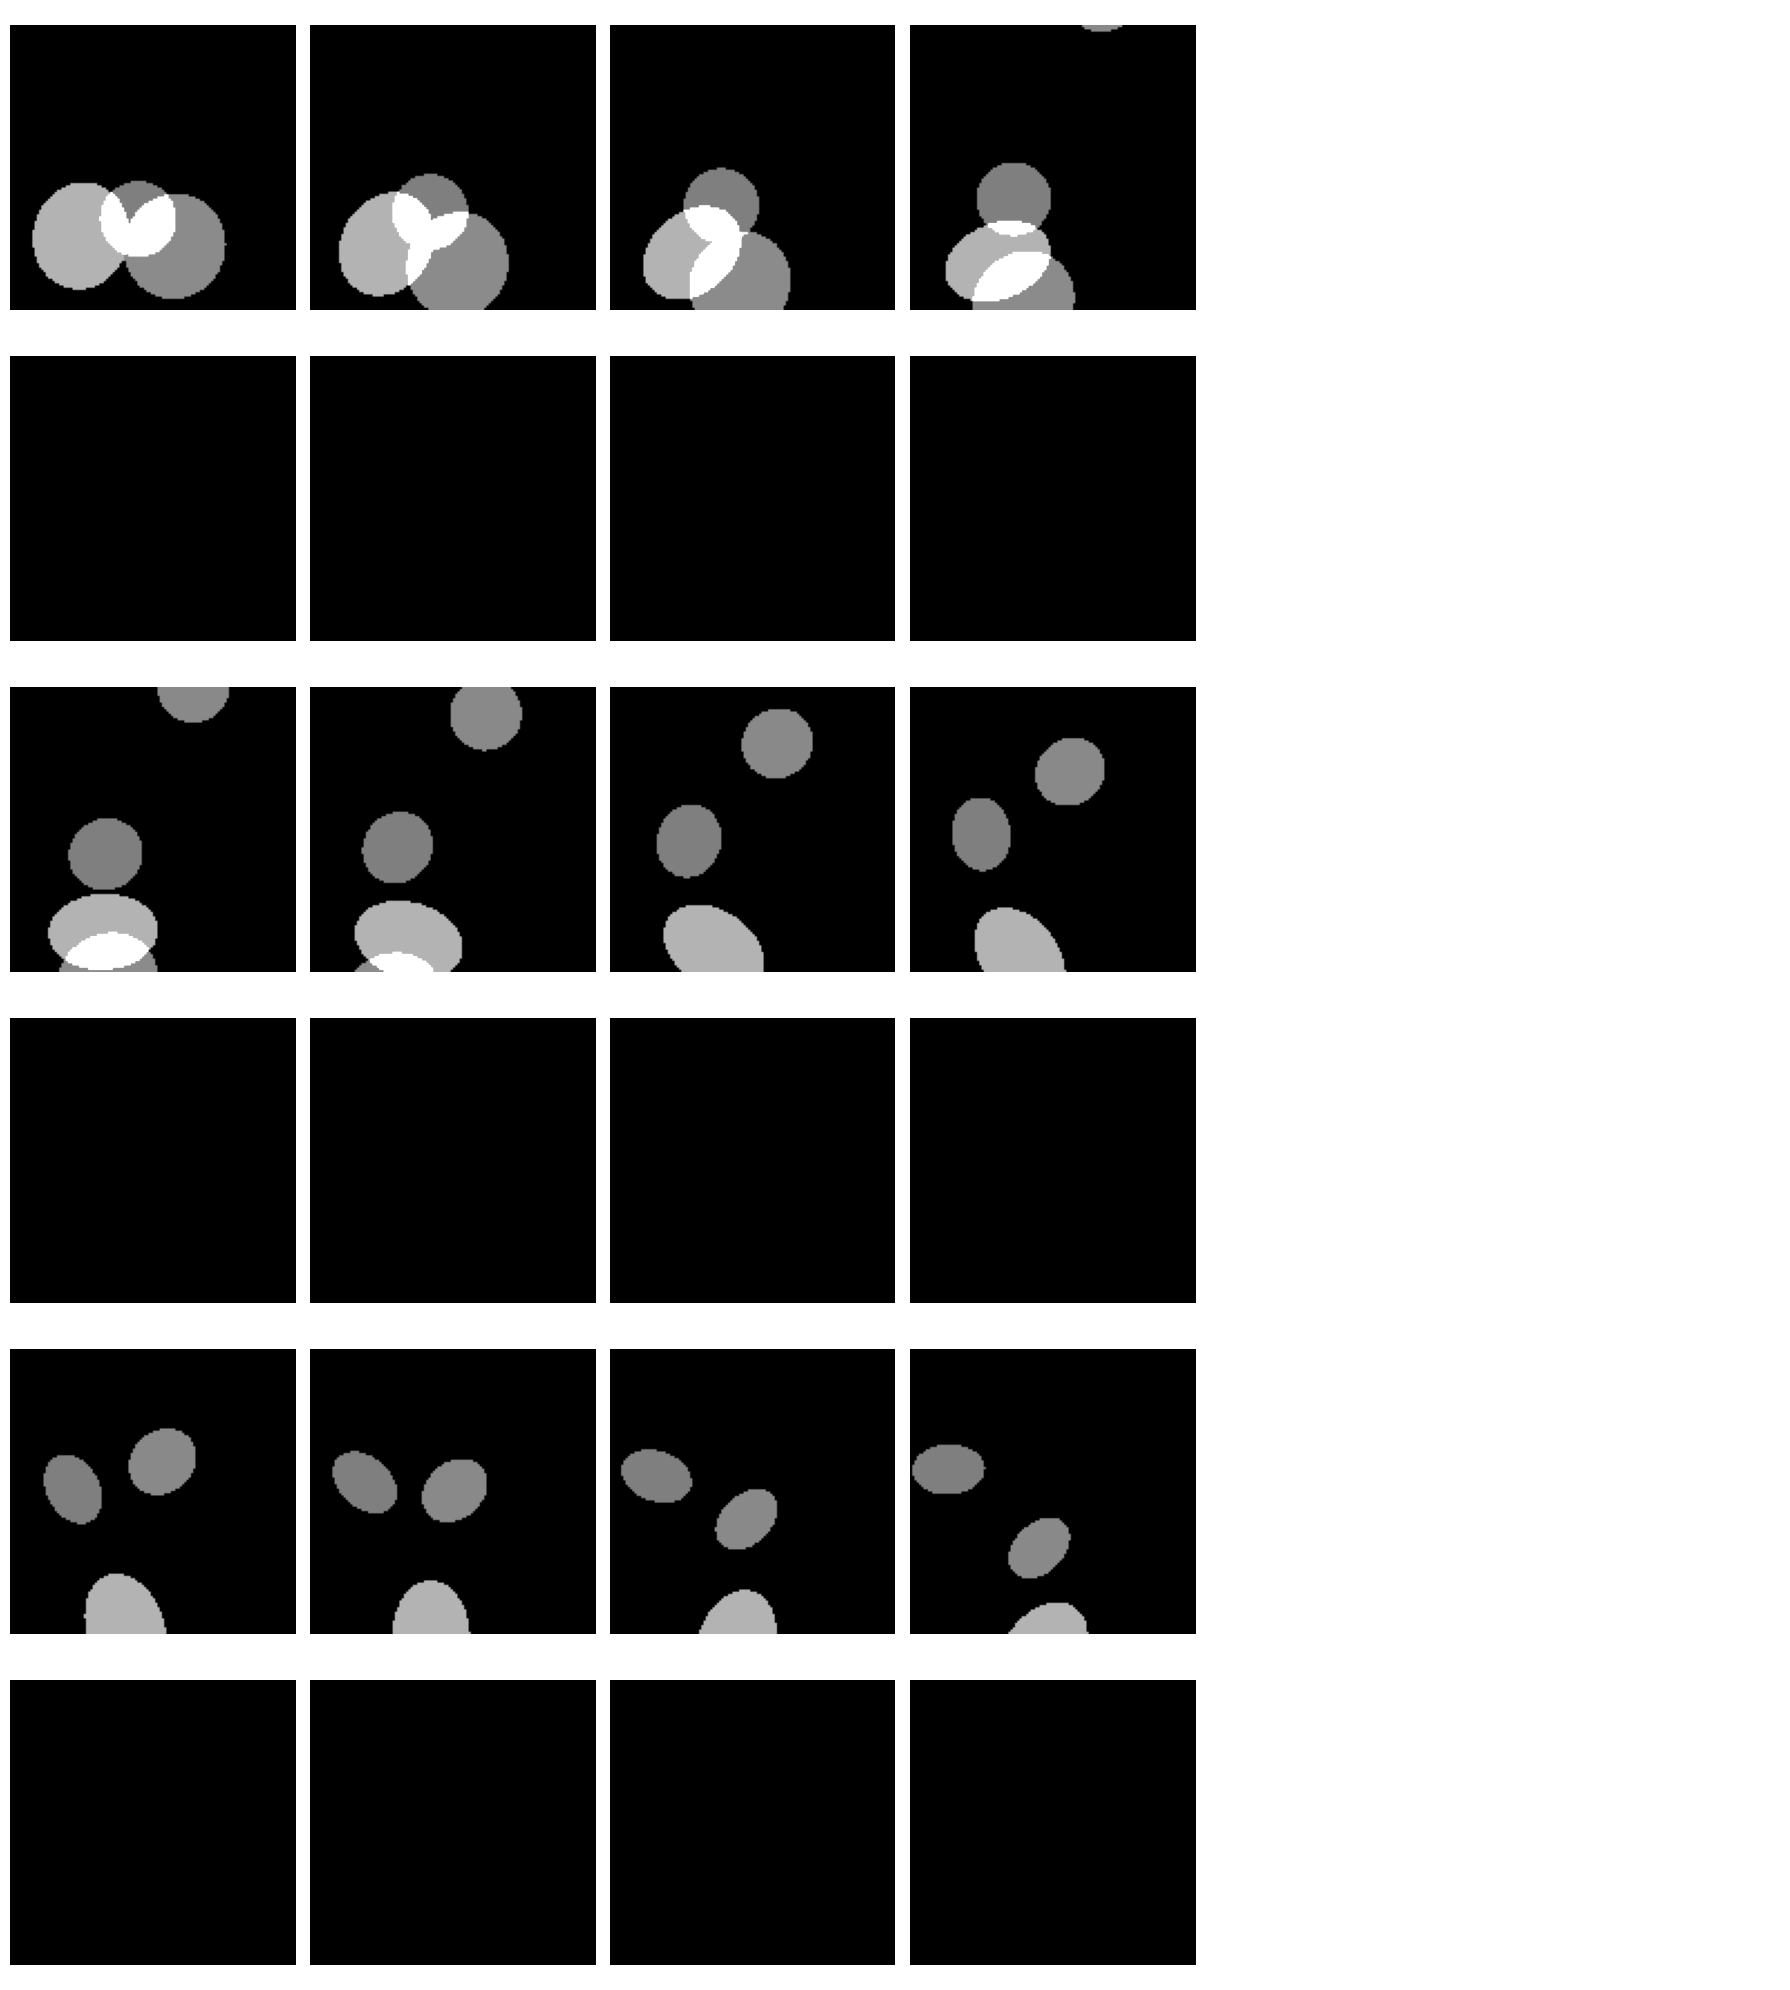

In [30]:
S = 172
# in the dataset :
# image = spatialized_gt(ndiscs=4, size=S, nsteps=12)
image = spatialized_gt(ndiscs=4, size=128, nsteps=12, centered=False)
device = torch.device('cpu')
images = torch.tensor(image).unsqueeze(0).float().to(device)


plot_images(image[:,0], image[:,1], 0)


In [13]:
S = 64
# in the dataset :
image = spatialized_gt(ndiscs=5, size=S, nsteps=60)
pairs, filter = create_cmls_filter(S, npairs = 20)
device = torch.device('cpu')
images = torch.tensor(image).unsqueeze(0).float().to(device)
pairs = torch.tensor(pairs).unsqueeze(0).float().to(device)
filters = torch.tensor(filter).unsqueeze(0).float().to(device)

# done on gpu:
point_measurements, _,  _ = point_gt(images, npoints=10)
segment_measurements, _ = segment_gt(images, pairs, filters)

images2 = make_noisy_images(images)
images = set_tensor_values2(images, point_measurements)

IndexError: index 12 is out of bounds for axis 0 with size 12

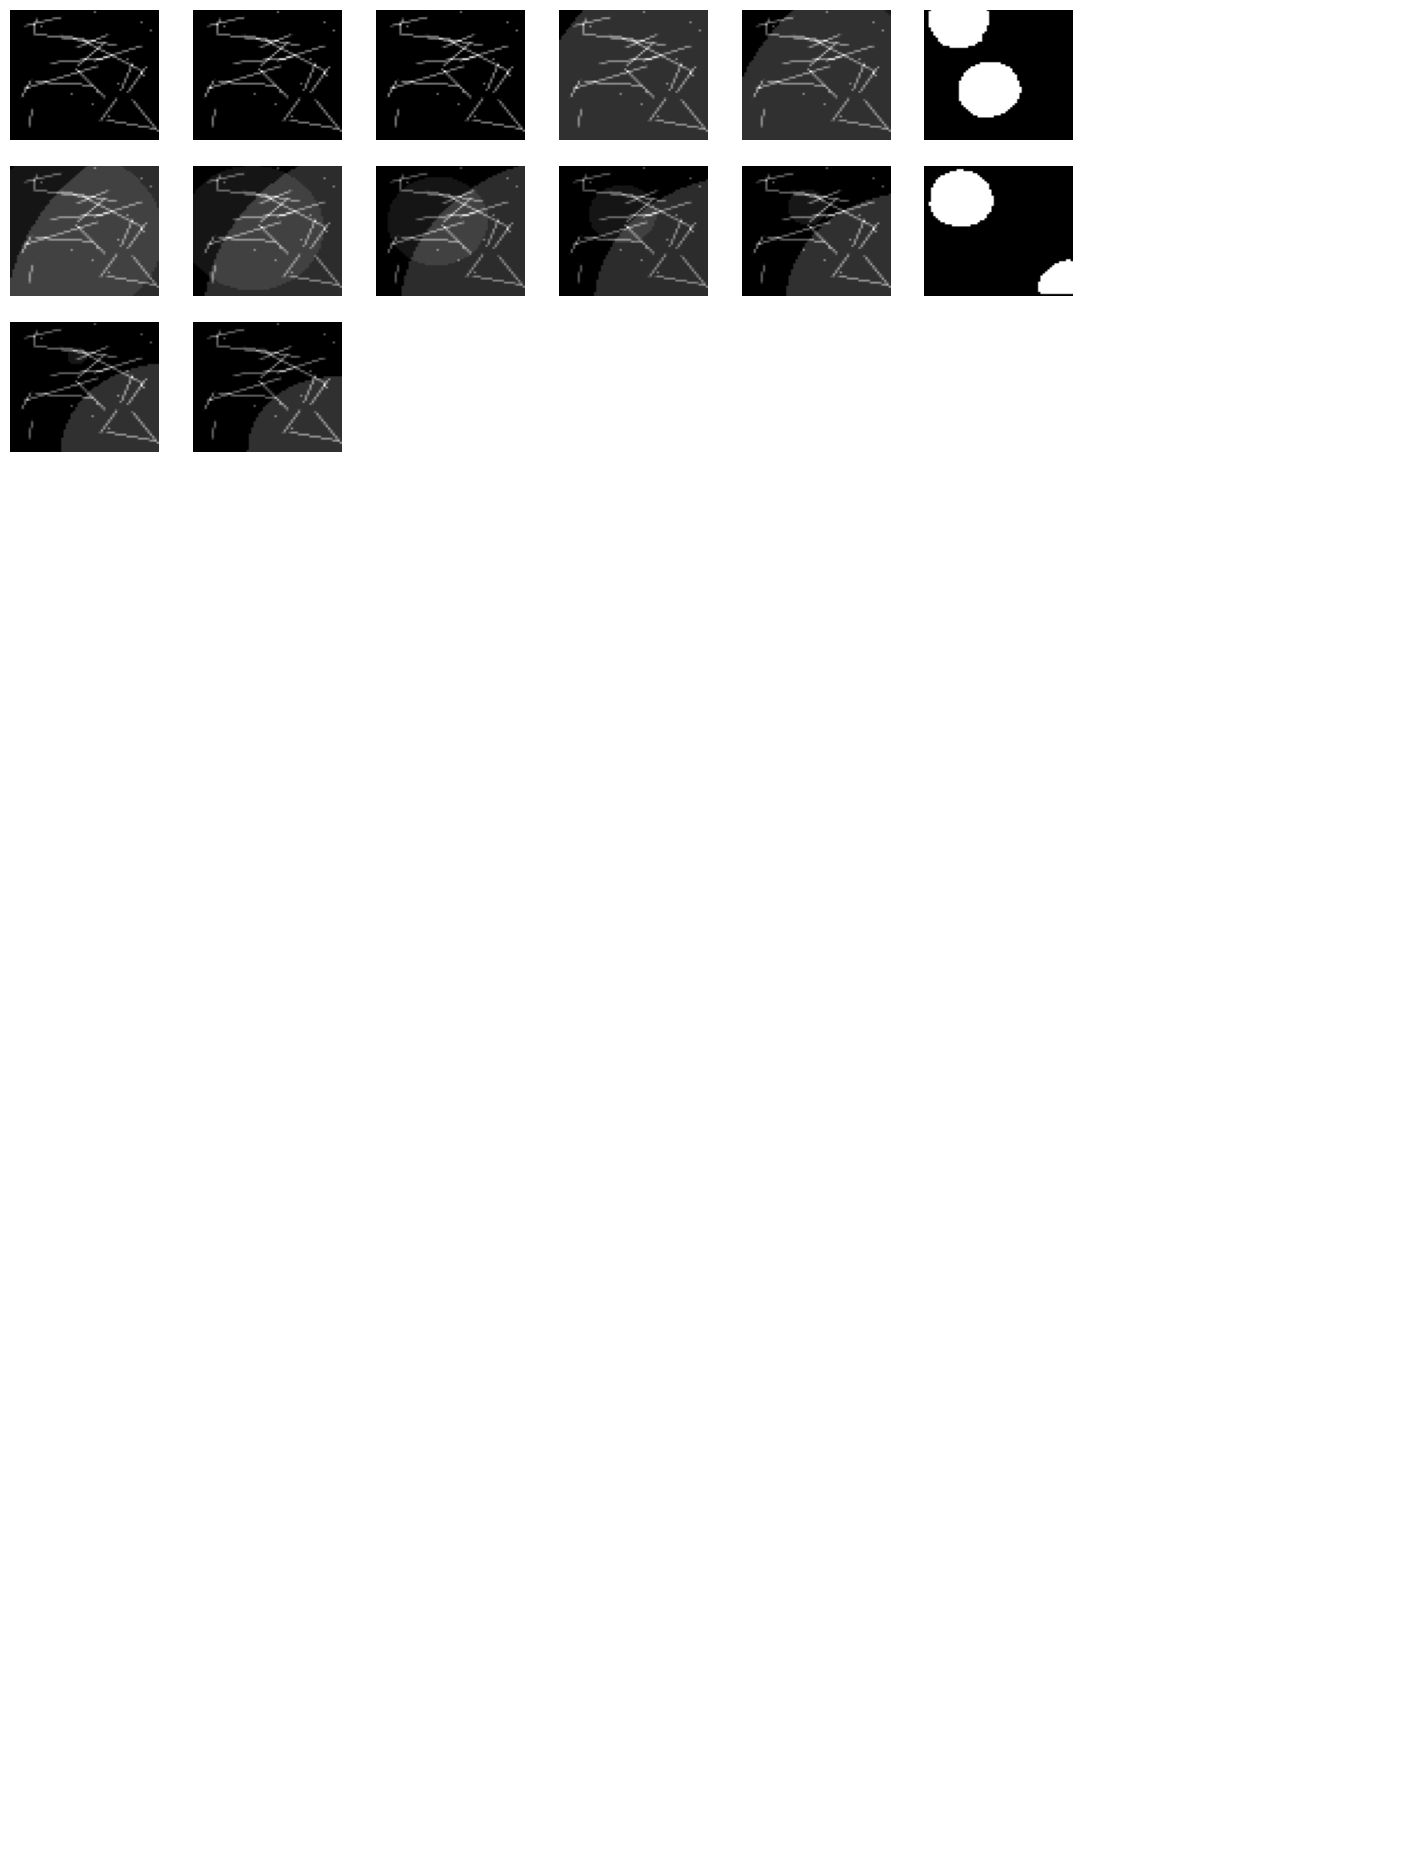

In [30]:
# Exemple / tracés
images = set_tensor_values2(images, point_measurements)

plot_images(images.cpu().numpy().squeeze(0) + filter.sum(axis=0),
            images2.squeeze(0).cpu().numpy(),
            point_measurements.cpu().numpy().squeeze(0),
            segment_measurements.cpu().numpy().squeeze(0))

"""
plot_results_10pts_20seg(
            images.cpu().numpy().squeeze(0) + filter.sum(axis=0),
            images2.squeeze(0).cpu().numpy(),
            point_measurements.cpu().numpy().squeeze(0),
            segment_measurements.cpu().numpy().squeeze(0),
            images.cpu().numpy().squeeze(0) + filter.sum(axis=0),
            images2.squeeze(0).cpu().numpy(),
            point_measurements.cpu().numpy().squeeze(0),
            segment_measurements.cpu().numpy().squeeze(0)
            )
"""

In [8]:
# Viz

def set_tensor_values2(X, extracted_data):
    """
    Set values in tensor X using coordinates and values extracted from another tensor.

    Args:
    X (torch.Tensor): Target tensor where values need to be set, shape (N, nc, S, S).
    extracted_data (torch.Tensor): Data containing normalized coordinates and values, shape (N, 2+M, npoints).
    S (int): Size of the spatial dimension of X.

    Returns:
    torch.Tensor: Updated tensor X with new values set at specified coordinates.
    """
    N, nc, S, _ = X.shape
    N, Mp2, npoints = extracted_data.shape
    M = Mp2 - 2

    # Extract normalized coordinates and values
    xs = extracted_data[:, 0, :]
    ys = extracted_data[:, 1, :]
    values = extracted_data[:, 2:, :]

    # Convert normalized coordinates back to original scale
    # ys = (1 - rows.float()/S) - 1/(2*S)
    # xs = cols.float()/S + 1/(2*S)

    rows = ((1 - (ys + 1/(2*S))) * S).long()
    cols = ((xs - 1/(2*S)) * S).long()

    # Use the coordinates to set the values in X
    for i in range(N):
        for j in range(npoints):
            X[i, :, rows[i, j], cols[i, j]] = values[i, :, j] + (values[i, :, j] > -1)

    return X


import matplotlib.gridspec as gridspec
def plot_images(images, noisy_images, point_measurements, segment_measurements):
    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(18, 24))
    gs = gridspec.GridSpec(12, 7, width_ratios=[1, 1, 1, 1, 1, 1, 2])  # Last column twice as wide

    # Manually create axes array for uniform handling as before
    axs = [fig.add_subplot(gs[i, j]) for i in range(12) for j in range(7)]

    # Hide all primary spines and ticks
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)

    # Image and noisy image plots
    for i in range(12):
        image_indices = [5*i, 5*i+1, 5*i+2, 5*i+3, 5*i+4, 5*i]
        noisy_index = i
        for j in range(6):
            ax = axs[i*7 + j]
            img = noisy_images[noisy_index] if j == 5 else images[image_indices[j]]
            img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img_normalized, cmap='gray', aspect='auto')
            ax.axis('off')

    # Point and Segment measurements plots
    for row in range(12):
        ax_main = axs[row * 7 + 6]  # Last column in each row
        if row < 2:  # First two rows for point measurements
            for idx in range(3) if row == 0 else range(2):
                ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                ax.plot(point_measurements[2:, idx + row*3], marker='.', markevery=(4, 5), markeredgewidth=2, markeredgecolor='black')
                label = f"Pluvio {idx+1 + row*3}"
                ax.set_ylim([-0.1, 1.5])
                coord1 = f"x={point_measurements[0, idx + row*3]:.2f}"  # First coordinate on a new line
                coord2 = f"y={point_measurements[1, idx + row*3]:.2f}"  # Second coordinate on another new line
                full_label = f"{label}\n{coord1}\n{coord2}"  # Combine into one string with two newlines
                ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                ax.yaxis.set_label_coords(0.05, 0.4)
                ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                for spine in ax.spines.values():
                    spine.set_visible(False)

        elif 2 <= row < 6:  # Next four rows for segment measurements
            for idx in range(3):
                actual_idx = 3 * (row - 2) + idx
                if actual_idx < 10:  # Ensure we don't exceed the 10 graphs
                    ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                    ax.plot(segment_measurements[4:, actual_idx], marker='.', markevery=(4, 5), markeredgewidth=1, markeredgecolor='black')
                    ax.set_ylim([-0.1, 1.5])
                    label = f"CML {actual_idx+1}"
                    coord_text = f"x1={segment_measurements[0, actual_idx]:.2f}, y1={segment_measurements[1, actual_idx]:.2f}\nx2={segment_measurements[2, actual_idx]:.2f}, y2={segment_measurements[3, actual_idx]:.2f}"
                    full_label = f"{label}\n{coord_text}"
                    ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                    ax.yaxis.set_label_coords(0.05, 0.4)
                    ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                    for spine in ax.spines.values():
                        spine.set_visible(False)
    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.1, wspace=0.05)  # Adjust overall spacing

    plt.tight_layout()
    plt.show()



def plot_results_10pts_20seg(images, noisy_images, point_measurements, segment_measurements, images_pred, images_pred_5min_mask, point_measurements_pred, segment_measurements_pred):
    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(18, 48))
    gs = gridspec.GridSpec(24, 7, width_ratios=[1, 1, 1, 1, 1, 1, 2])  # Last column twice as wide

    # Manually create axes array for uniform handling as before
    axs = [fig.add_subplot(gs[i, j]) for i in range(24) for j in range(7)]

    # Hide all primary spines and ticks
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)

    # Image and noisy image plots
    for i in range(12):
        image_indices = [5*i, 5*i+1, 5*i+2, 5*i+3, 5*i+4, 5*i]
        noisy_index = i
        for j in range(6):
            ax = axs[i*14 + j]
            img = noisy_images[noisy_index] if j == 5 else images[image_indices[j]]
            # img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect='auto')
            ax.axis('off')

    # Outputs and masked output plots
    for i in range(12):
        image_indices = [5*i, 5*i+1, 5*i+2, 5*i+3, 5*i+4, 5*i]
        noisy_index = i
        for j in range(6):
            ax = axs[7 + i*14 + j]
            img = images_pred_5min_mask[noisy_index] if j == 5 else images_pred[image_indices[j]]
            # img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect='auto')
            ax.axis('off')

    # Point and Segment measurements plots
    for row in range(12):
        ax_main = axs[row * 7 + 6]  # Last column in each row
        if row < 4:  # First four rows for point measurements
            for idx in range(3) if row in [0,1,2] else range(1):
                ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                ax.plot(point_measurements[2:, idx + row*3], marker='.', markevery=(4, 5), markeredgewidth=2, markeredgecolor='black')
                ax.plot(point_measurements_pred[2:, idx + row*3], marker='.', markevery=(4, 5), markeredgewidth=2, markeredgecolor='black', color='red')
                label = f"Pluvio {idx+1 + row*3}"
                ax.set_ylim([-0.1, 1.5])
                coord1 = f"x={point_measurements[0, idx + row*3]:.2f}"  # First coordinate on a new line
                coord2 = f"y={point_measurements[1, idx + row*3]:.2f}"  # Second coordinate on another new line
                full_label = f"{label}\n{coord1}\n{coord2}"  # Combine into one string with two newlines
                ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                ax.yaxis.set_label_coords(0.05, 0.4)
                ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                for spine in ax.spines.values():
                    spine.set_visible(False)

        elif 4 <= row < 11:  # Next 7 rows for segment measurements
            for idx in range(3) if row in [4,5,6,7,8,9,10] else range(1):
                actual_idx = 3 * (row - 4) + idx
                if actual_idx < 20:  # Ensure we don't exceed the 20 graphs
                    ax = ax_main.inset_axes([0, 1 - (idx+1)/3, 1, 1/3])
                    ax.plot(segment_measurements[4:, actual_idx], marker='.', markevery=(4, 5), markeredgewidth=1, markeredgecolor='black')
                    ax.plot(segment_measurements_pred[4:, actual_idx], marker='.', markevery=(4, 5), markeredgewidth=1, markeredgecolor='black',color='red')
                    ax.set_ylim([-0.1, 1.5])
                    label = f"CML {actual_idx+1}"
                    coord_text = f"x1={segment_measurements[0, actual_idx]:.2f}, y1={segment_measurements[1, actual_idx]:.2f}\nx2={segment_measurements[2, actual_idx]:.2f}, y2={segment_measurements[3, actual_idx]:.2f}"
                    full_label = f"{label}\n{coord_text}"
                    ax.set_ylabel(full_label, rotation=0, labelpad=0, fontsize=6)
                    ax.yaxis.set_label_coords(0.05, 0.4)
                    ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
                    for spine in ax.spines.values():
                        spine.set_visible(False)
    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.1, wspace=0.05)  # Adjust overall spacing

    plt.tight_layout()
    plt.show()
